In [1]:
# Imports

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Conv1D
from keras.layers import Bidirectional, concatenate, SpatialDropout1D, GlobalMaxPooling1D

In [2]:
def read_data():
    os.chdir('D:/TU_Graz/Thesis/Datasets/Reddit_features')
    train = pd.read_csv("train_final_all.csv")
    test = pd.read_csv("test_final_all.csv")
    data = train.append(test)
    return train, test, data

In [3]:
def create_lists(data, category):
    words = list(set(data["Token"].values))
    words.append("ENDPAD")
    n_words = len(words)

    tags = list(set(data[category].values))
    n_tags = len(tags)
    
    chars = set([w_i for w in words for w_i in w])
    n_chars = len(chars)
    
    return words, n_words, tags, n_tags, chars, n_chars

In [4]:
def group_sentences(data, category):
    all_sents = []
    sent_ids = data['Sent_id'].unique()
    for curr_id in sent_ids:
        tmp_df = data[data['Sent_id'] == curr_id]
        tmp_df = pd.concat([tmp_df['Token'], tmp_df["Token_index"], tmp_df.iloc[:,4:44], tmp_df[category]], axis = 1)
        #tmp_df = pd.concat([tmp_df['Token'], tmp_df["Token_index"], tmp_df.iloc[:,4:149], tmp_df[category]], axis = 1)
        records = tmp_df.to_records(index=False)
        all_sents.append(records)
    return all_sents

In [5]:
def remove_sents_over_threshold(sents, threshold):
    sentences = list()
    for s in sents:
        if len(s) < threshold:
            sentences.append(s)
    return sentences

In [6]:
def build_model(max_len, max_len_char, n_words, n_chars, n_tags):
    # input and embedding for words
    word_in = Input(shape=(max_len,))
    emb_word = Embedding(input_dim=n_words, output_dim=50, input_length=max_len, mask_zero=True)(word_in)

    # input and embeddings for characters
    char_in = Input(shape=(max_len, max_len_char,))
    emb_char = TimeDistributed(Embedding(input_dim=n_chars+1, output_dim=50, input_length=max_len_char, mask_zero=True))(char_in)
    # character LSTM to get word encodings by characters
    char_enc = TimeDistributed(LSTM(units=50, return_sequences=False, recurrent_dropout=0.5))(emb_char)

    # main LSTM
    x = concatenate([emb_word, char_enc])
    x = SpatialDropout1D(0.3)(x)
    main_lstm = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.7))(x)
    out = TimeDistributed(Dense(n_tags, activation="sigmoid"))(main_lstm)

    model = Model([word_in, char_in], out)
    
    return model

In [7]:
def plot_learning_curves(hist, curve1, curve2):
    plt.style.use("ggplot")
    plt.figure(figsize=(10, 7))
    plt.plot(hist[curve1])
    plt.plot(hist[curve2])
    plt.show()

Loading the data...
Creating sets of words and tags...
Creating sentence list...
Removing submissions longer than threshold...
Creating word, char and tag maps...
Preparing and padding training data...
Splitting data...
Building the model...
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 300, 10)]    0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 300)]        0                                            
__________________________________________________________________________________________________
time_distributed (TimeDistribut (None, 300, 10, 50)  5050        input_2[0][0]                    
__________________________________________________

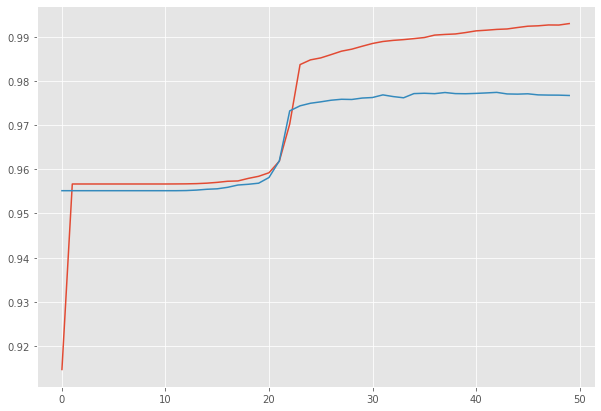

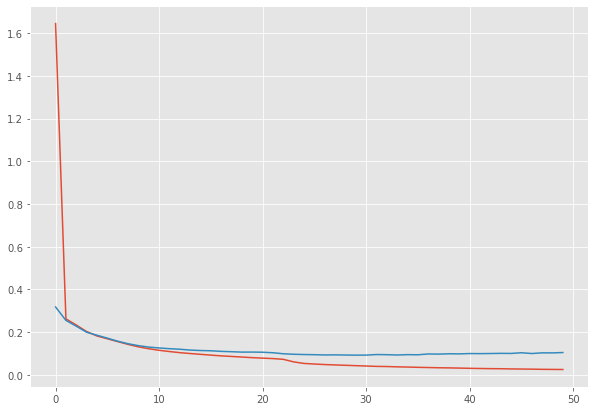

In [8]:
print("Loading the data...")
train, test, data = read_data()

print("Creating sets of words and tags...")
words, n_words, tags, n_tags, chars, n_chars = create_lists(data, "BIO")

print("Creating sentence list...")
sents = group_sentences(data, 'BIO')

print("Removing submissions longer than threshold...")
sentences = remove_sents_over_threshold(sents, 300)

print("Creating word, char and tag maps...")
max_len = 300
max_len_char = 10
word2idx = {w: i for i, w in enumerate(words)}
idx2word = {i: w for w, i in word2idx.items()}
tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {i: w for w, i in tag2idx.items()}
char2idx = {c: i for i, c in enumerate(chars)}

print("Preparing and padding training data...")
X_word = [[word2idx[w[0]] for w in s] for s in sentences]
X_word = pad_sequences(maxlen=max_len, sequences=X_word, value=n_words-1, padding='post', truncating='post')
X_char = []
for sentence in sentences:
    sent_seq = []
    for i in range(max_len):
        word_seq = []
        for j in range(max_len_char):
            try:
                word_seq.append(char2idx.get(sentence[i][0][j]))
            except:
                word_seq.append(n_chars)
        sent_seq.append(word_seq)
    X_char.append(np.array(sent_seq))
    
y = [[tag2idx[w[len(w)-1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, value=tag2idx["O"], padding='post', truncating='post')

print("Splitting data...")
X_word_train, X_word_test, y1_train, y1_test = train_test_split(X_word, y, test_size=0.25, shuffle=False)
X_char_train, X_char_test, y2_train, y2_test = train_test_split(X_char, y, test_size=0.25, shuffle=False)
y_test = y1_test
y_train = y1_train

print("Building the model...")
model = build_model(max_len, max_len_char, n_words, n_chars, n_tags)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc"])
model.summary()

print("Fitting the model...")
history = model.fit([X_word_train, np.array(X_char_train).reshape((len(X_char_train), max_len, max_len_char))], 
                    np.array(y_train).reshape(len(y_train), max_len, 1), batch_size=32, epochs=50, validation_split=0.2, 
                    verbose=1)
hist = pd.DataFrame(history.history)

# Plotting learning curves
print("Plotting learning curves...")
plot_learning_curves(hist, "acc", "val_acc")
plot_learning_curves(hist, "loss", "val_loss")

In [12]:
y_pred = model.predict([X_word_test, np.array(X_char_test).reshape((len(X_char_test), max_len, max_len_char))])
p = np.argmax(y_pred, axis=-1)
y_orig = []
for sent in y_test:
    for tag in sent:
        y_orig.append(tag)
        
y_preds = []
for sent in p:
    for tag in sent:
        y_preds.append(tag)
        
report = classification_report( y_orig, y_preds )
print(report)    

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        19
           1       0.87      0.79      0.82      1814
           2       0.85      0.76      0.81      1409
           3       0.00      0.00      0.00        32
           4       0.18      0.05      0.08        37
           5       0.08      0.03      0.04        33
           6       0.99      0.99      0.99    104277
           7       0.72      0.86      0.78       214
           8       1.00      0.39      0.56        46
          10       0.49      0.41      0.45       750
          11       0.00      0.00      0.00        28
          12       0.00      0.00      0.00        21
          13       0.00      0.00      0.00         4
          14       0.14      0.02      0.03        56
          15       0.36      0.21      0.26       456
          16       0.00      0.00      0.00         4

    accuracy                           0.98    109200
   macro avg       0.36   

C:\Users\Kiki\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [14]:
tag2idx

{'B-gen-neg': 0,
 'I-movie-pos': 1,
 'B-movie-pos': 2,
 'I-movie-neg': 3,
 'B-actor-pos': 4,
 'I-actor-pos': 5,
 'O': 6,
 'B-gen-pos': 7,
 'I-gen-pos': 8,
 'I-gen-neg': 9,
 'B-keyword-pos': 10,
 'I-keyword-neg': 11,
 'B-movie-neg': 12,
 'I-actor-neg': 13,
 'B-keyword-neg': 14,
 'I-keyword-pos': 15,
 'B-actor-neg': 16}

In [91]:
i = 19
p = np.argmax(y_pred[i], axis=-1)
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_word_te[i], y_te[i], p):
    if w != n_words-1:
        print("{:15}: {:5} {}".format(idx2word[w], idx2tag[t], idx2tag[pred]))

Word           ||True ||Pred
Movies         : O     O
with           : O     O
a              : O     O
twist          : B-keyword-pos B-keyword-pos
?              : O     O
I              : O     O
hate           : O     O
asking         : O     O
for            : O     O
this           : O     O
,              : O     O
as             : O     O
knowledge      : O     O
of             : O     O
a              : O     O
twist          : B-keyword-pos B-keyword-pos
alone          : O     O
can            : O     O
itself         : O     O
ruin           : O     O
the            : O     O
twist          : B-keyword-pos B-keyword-pos
BUT            : O     O
then           : O     O
again          : O     O
,              : O     O
I              : O     O
feel           : O     O
like           : O     O
I              : O     O
have           : O     O
seen           : O     O
them           : O     O
all            : O     O
.              : O     O
Looking        : O     O
for        